Diese Sitzung behandelt die Arbeit mit der fastai Library zur Arbeit mit visuellen Daten. In dieser Sitzung besprechen wir Beispiele aus der fastai-Dokumentation. Diese finden sich unter folgendem Link:
https://docs.fast.ai/tutorial.vision.html


## Wichtig: Jedes fastai Beispiel (und spätere Projekt) folgt den  4 Schritten:
1. Eine gleich bleibende API/Schnittstelle zur Sammlung und Analyse von Daten verwenden sowie der Erstellung von Labeln
2. Einen "Learner" erstellen: dieser kombiniert Daten und Modelle für das Training und benutzt bereits vorgefertigte Modelle um die Trainingsdauer zu reduzieren
3. Das Training des Modells
4. Die Überprüfung einiger Vorhersagen des Modells

## 1. Import und Update der Library

fastai ist eine externe Library aus der Sicht von Google Colab. Diese muss vor Start der Arbeit manuell installiert und aktualisiert werden. Import und Update führen wir mit folgendem Codezeilen durch:

In [1]:
! [ -e /content ] && pip install -Uqq fastai

In [2]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.1 MB/s eta 0:00:00


In [3]:
import fastbook

In [4]:
import fastai

In [5]:
from fastai.vision.all import *

In [6]:
from ipywidgets import HBox,VBox,widgets,Button,Checkbox,Dropdown,Layout,Box,Output,Label,FileUpload

## 2. Erstellen eines DL Modells zur Identizifizierung von Katzen und Hunden

### 2.1.1 Laden und sammeln des Oxford-IIIT Pet Datasets

Wir speichern den Datensatz wie immer in einer ständigen Variable. Die folgende Funktion läd für uns automatisch den Datensatz herunter und entpackt ihn:

In [7]:
path = untar_data(URLs.PETS)

Im nächsten Schritt können wir uns den Speicherort der Datei in unserem Colab-Umfeld ansehen:

In [8]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

Hierbei handelt es sich um eine virtuelle, temporäre Pfadumgebung, die nach dem Beenden des Notebooks ebenfalls gelöscht wird.

Nun definieren wir eine Variable, die uns alle Bilder, die sich in dem Pfad befinden, speichert:

In [9]:
files = get_image_files(path/"images")

Die Anzahl der geladenen Bilder können wir mit der len() Funktion ermitteln:

In [10]:
len(files)

7390

### 2.1.2 Erstellung von Labeln für die geladenen Daten

Erinnerung: Um ein Modell zu trainieren benötigen wir Daten mit sogenannten Labeln, damit unser Modell die Charakteristika verschiedener Label-Gruppen trainieren kann. Um Katzenfotos zu identifizieren, wurden in diesem Datensatz alle Katzenbilder am Anfang klein geschrieben, wohingegen Hundebilder groß geschrieben wurden.

Diese Unterscheidungsmethode kann auf beliebig andere Bilder angewendet werden. Es existieren natürlich viele weitere Methoden, um Bilder zu labeln, damit ein Modell damit trainiert werden kann. Beispielsweise kann man in einer Tabelle die Dateinamen und deren zugehöriges Label speichern.

Mit dem folgenden Code schauen wir uns einzelne Dateien an:

In [11]:
files[0],files[6], files[7], files[39]

(Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_76.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_36.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_84.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_196.jpg'))

Über die folgende Funktion werden die einzelnen Dateien dann gelabelt:

In [12]:
def label_func(f): return f[0].isupper()

Zur Vorbereitung von Daten für ein Modell verwendet fastai sogenannte "DataLoaders". Zur Vorbereitung der Daten für das Modell wurden verschiedene Funktionen entworfen.
Da in unserem Fall der Name der Datei Aufschluss darüber gibt, um was für ein Label es sich handelt, verwenden wir die "ImageDataLoaders.from_name_func", also eine Funktion, die Bilder ihre Label basierend auf dem Dateinamen zuweist.

Es gibt viele weitere Möglichkeiten, um mit "DataLoaders" Bilder zu labeln. Weitere Informationen finden sich in der fastai-Dokumentation unter:
https://docs.fast.ai/vision.data.html#ImageDataLoaders

Die resultierenden Label mit Bildern werden, ähnlich wie bei einem DataFrame, in einer eigenen Variable gespeichert:

In [13]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

An dieser Stelle haben wir unser Modell noch nicht auf die Bilder trainiert, allerdings jedem Bild ein Label zugewiesen. Mit diesen gelabelten Bildern können wir unser Modell später trainieren.

Folgende Dinge sind in dieser Funktion enthalten:
- Der Pfad ("Path"), unter dem die Bilder gespeichert werden
- Die Dateien ("Files"), welche wir verwenden wollen. In diesem Fall "pictures" aus dem enthaltenen Pfad
- Unsere Label Funktion, die jedem Bild, basierend auf Groß- oder Kleinschreibung, das Label Katze oder Hund zuweist
- einen Transformer, der alle Bilder auf die Größe 224*224 ändert. Dies machen wir, weil die Bilder zum Training des Modells eine einheitliche Größe brauchen.

Wir können uns nun einige Bilder durch die sogenannte "show_batch" Methode anzeigen lassen. Eine Batch ist einfach eine Ladung oder "Charge" von Gegenständen, in diesem Fall Bildern. Merke: In diesem Fall handelt es sich um eine binäre Klassifizierung, entweder 0 oder 1, wahr oder falsch. Katzen werden hier mit "true", Hunde mit "false" identifiziert:

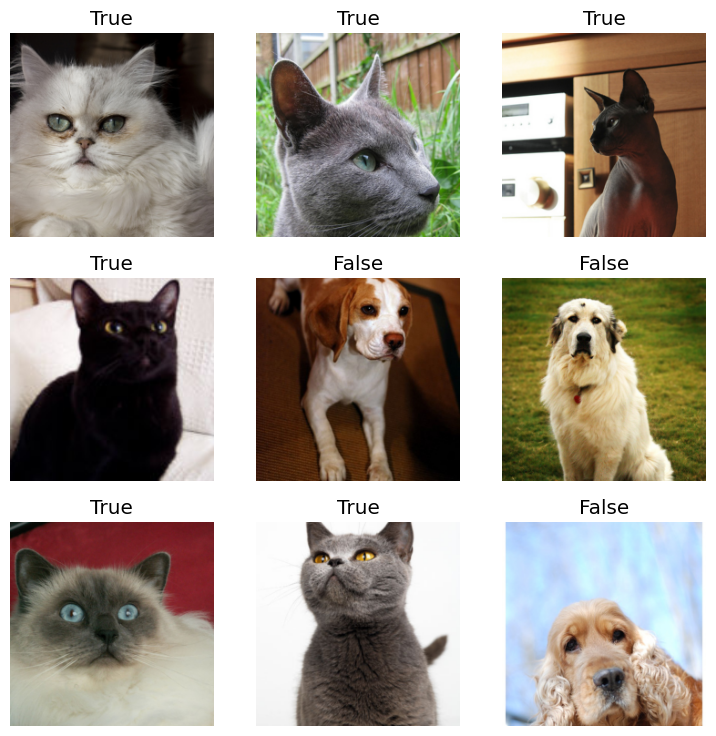

In [14]:
dls.show_batch()

###2.2 Erstellung eines Learners

Ein Learner in fastai kombiniert Daten und Modelle für die Trainingsphase eines Modells. Er enthält die folgenden Komponenten:
- Unseren vorher definierten ImageLoader
- Ein vortrainiertes Modell unserer Wahl
- Eine Metrik oder sogenannte Loss-Funktion, die das Modell optimieren soll

Der Learner setzt außerdem sogenanntes TransferLearning ein. Bei TransferLearning verwenden wir bereits trainierte Modelle, um uns Trainigszeit zu sparen. Ein eigenes, neuronales Netzwerk müsste komplett ohne Einstellungen beginnen, die Bilder zu lernen, damit es diese besser vorhersagen kann. Wenn wir ein bereits trainiertes Modell verwenden, müssen wir dieses lediglich "fine-tunen", also nur leichte Veränderungen vornehmen, um es für unsere Daten zu optimieren.

Die folgende Zeile lädt ein vortrainiertes Modell:

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


###2.3 Training des Modells

Die folgende Zeile passt dieses vorgefertigte Modell auf unsere Daten an:

In [ ]:
#learn.fine_tune(1)

In [16]:
learn.fine_tune(0)

epoch,train_loss,valid_loss,error_rate,time
0,0.139159,0.016585,0.005413,00:45


Hier sehen wir einige Dinge, die uns bekannt vorkommen sollten:
- Epoche gibt die Runde an, in der das Modell trainiert wird. Mehr Epochen benötigen länger.
- Train-Loss gibt die Güte des Modells während der Trainingsphase an
- Validation-Loss gibt die Güte des Modells während der Validierungsphase an (Sitzung 11); diese sollte idealerweise besser sein als der Train-Loss, da das Modell bereits mit Daten trainiert wurde
- Die Error-Rate berechnet sich aus: 1- Accuracy. Das heißt in diesem Fall wurden nur 0.3% der Bilder falsch vorhergesagt oder 99.97% der Vorhersagen sind korrekt.
- Zeit gibt an, wie lange ein Modell trainiert wurde

Mehr dazu findet sich in der Dokumentation zu Metriken:
https://docs.fast.ai/metrics.html#accuracy

###2.4 Validierung der Ergebnisse

Zur Validierung der Ergebnisse stehen uns verschiedene Methoden zur Verfügung:
Wir können
- die .predict Funktion verwenden, um die Kategorie einer der Bilder aus unserem Datensatz vorherzusagen
- Uns mit learn.show_results() die Ergebnisse unseres Modells anzeigen lassen
- Ein eigenes Bild hochladen und dessen Kategorie durch unser Modell vorhersagen lassen  

Diese werden alle auf unsere learn Variable angewendet, worunter wir unser trainiertes Modell gespeichert haben.

Mit der .predict Funktion:

In [17]:
learn.predict(files[0])

('True', tensor(1), tensor([6.2877e-08, 1.0000e+00]))

Mit .show_results():

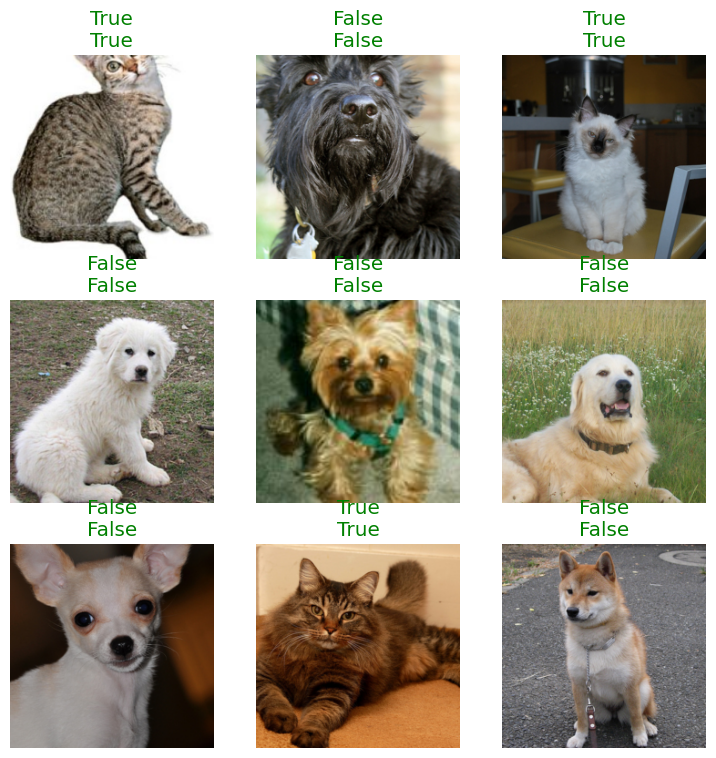

In [18]:
learn.show_results()

Das Upload-Widget, mit dem wir ein eigenes Bild hochladen können:

In [19]:
uploader = widgets.FileUpload()

In [20]:
uploader

FileUpload(value={}, description='Upload')

In [23]:
img = PILImage.create(uploader.data[0])

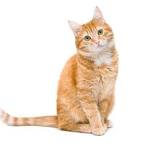

In [22]:
img

In [24]:
is_cat,_,probs = learn.predict(img)
print(f"Ist das eine Katze?: {is_cat}.")
print(f"Die Wahrscheinlichkeit, dass das eine Katze ist: {probs[1].item():.6f}")

Ist das eine Katze?: True.
Die Wahrscheinlichkeit, dass das eine Katze ist, ist: 1.000000
